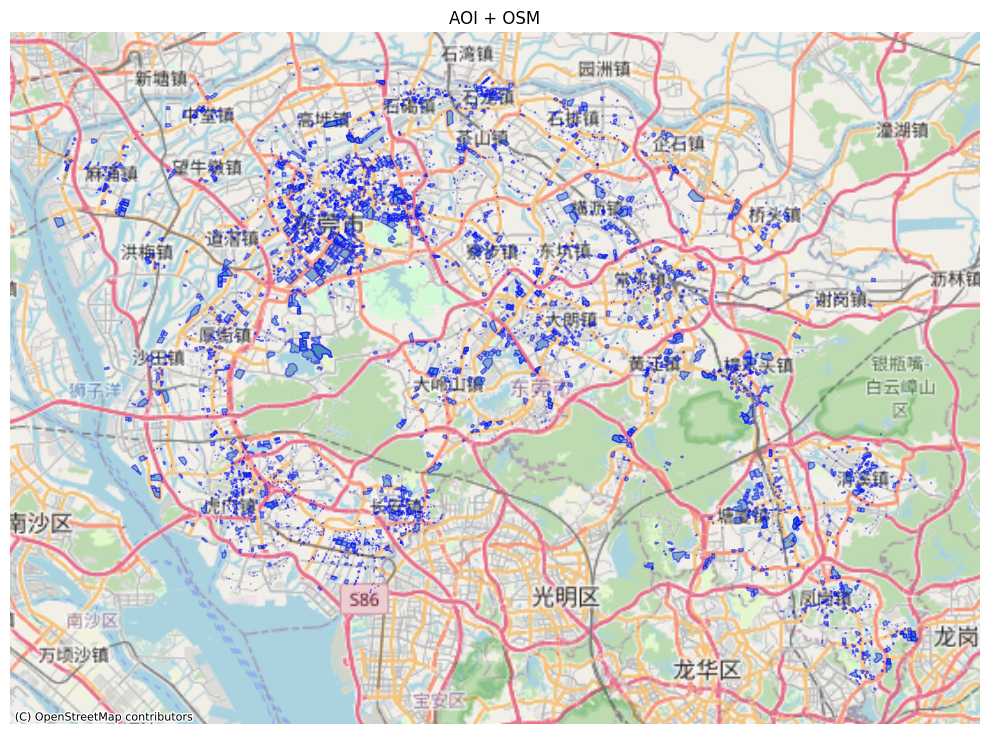

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 1. 读取并转坐标
aoi_path = "大湾区小区AOI/东莞市小区AOI2.shp"
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=4326)

# 3. 投影为 EPSG:3857（contextily 要求）
aoi_webmercator = aoi_gdf.to_crs(epsg=3857)

# 4. 绘图 + 添加底图
fig, ax = plt.subplots(figsize=(10, 10))
aoi_webmercator.plot(ax=ax, alpha=0.5, edgecolor='blue', linewidth=1)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("AOI + OSM")
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
import rasterio
with rasterio.open("20250723大湾区/东莞市1m/东莞市1m.tif") as src:
    print(src.crs)  # 若为 EPSG:4326，会显示 'EPSG:4326'


EPSG:4326


In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/东莞市1m/东莞市1m.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/东莞市1m/东莞市1m_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [16:42<00:00, 334.19s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/东莞市1m/东莞市1m_utm50.tif


In [12]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# === 路径设置 ===
aoi_path = "广州市小区AOI2/东莞市小区AOI2.geojson"            # 输入 AOI GeoJSON（WGS84）
raster_path = "20250723大湾区/东莞市1m/东莞市1m_utm50.tif"       # 输入遥感影像（EPSG:32650）
output_dir = "东莞数据集"   # 输出目录
os.makedirs(output_dir, exist_ok=True)

# === 图像保存函数：白色背景 ===
def save_png_from_array(out_image, output_path):
    if out_image.shape[0] == 1:
        img = out_image[0]
        # 将背景设为白色
        img_norm = ((img - img.min()) / (img.ptp() + 1e-5) * 255).astype(np.uint8)
        img_norm[img == 0] = 255  # 背景设为白
        Image.fromarray(img_norm, mode='L').save(output_path)
    
    elif out_image.shape[0] >= 3:
        rgb = np.transpose(out_image[:3], (1, 2, 0))
        # 归一化并设置背景为白色
        rgb_norm = ((rgb - rgb.min()) / (rgb.ptp() + 1e-5) * 255).astype(np.uint8)
        mask = np.all(rgb == 0, axis=-1, keepdims=True)
        rgb_norm = np.where(mask, 255, rgb_norm)
        Image.fromarray(rgb_norm, mode='RGB').save(output_path)
    else:
        raise ValueError("图像波段数不支持保存为 PNG")

# === 1. 读取 AOI 并投影为 UTM 50N ===
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=32650)

# === 2. 计算面积并过滤小于 1000 平方米的 AOI ===
aoi_gdf["area_m2"] = aoi_gdf.geometry.area
aoi_filtered = aoi_gdf[aoi_gdf["area_m2"] >= 1000].copy()
print(f"✅ 原始 AOI 数量：{len(aoi_gdf)}")
print(f"✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：{len(aoi_filtered)}")

# === 3. 为每个 AOI 添加 20 米缓冲区 ===
aoi_filtered["geometry"] = aoi_filtered.geometry.buffer(20)

# === 4. 处理所有符合条件的AOI ===
with rasterio.open(raster_path) as src:
    meta = src.meta
    failed_indices = []  # 记录失败案例

    # 使用tqdm显示整体进度
    for idx, row in tqdm(aoi_filtered.iterrows(), total=len(aoi_filtered), desc="处理AOI"):
        geom = [mapping(row["geometry"])]

        try:
            # === 裁剪遥感图像 ===
            # 添加nodata处理，防止黑色背景
            out_image, out_transform = mask(
                src, 
                geom, 
                crop=True, 
                nodata=src.nodata if src.nodata is not None else 0,
                all_touched=False
            )
            
            # === 保存为PNG ===
            png_path = os.path.join(output_dir, f"aoi_{idx}.png")
            save_png_from_array(out_image, png_path)

            # === 保存属性信息 ===
            props = row.drop("geometry").to_dict()
            props_serializable = {
                k: (
                    str(v) if isinstance(v, pd.Timestamp)
                    else int(v) if isinstance(v, (np.integer,))
                    else float(v) if isinstance(v, (np.floating,))
                    else str(v) if isinstance(v, (np.datetime64,))
                    else v
                )
                for k, v in props.items()
            }
            # 添加图像元数据
            props_serializable.update({
                "image_metadata": {
                    "shape": out_image.shape,
                    "transform": list(out_transform),
                    "crs": src.crs.to_string()
                }
            })
            
            json_path = os.path.join(output_dir, f"aoi_{idx}.json")
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(props_serializable, f, ensure_ascii=False, indent=2)

        except Exception as e:
            failed_indices.append(idx)
            print(f"[⚠️] AOI {idx} 处理失败：{str(e)}")
            continue

# === 5. 输出统计信息 ===
print("\n=== 处理结果统计 ===")
print(f"成功处理: {len(aoi_filtered) - len(failed_indices)}个")
print(f"失败数量: {len(failed_indices)}个")
if failed_indices:
    print(f"失败索引: {failed_indices}")

✅ 原始 AOI 数量：5028
✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：3048


处理AOI: 100%|█████████████████████████████████████████████████████████████████████| 3048/3048 [02:03<00:00, 24.59it/s]



=== 处理结果统计 ===
成功处理: 3048个
失败数量: 0个


In [2]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/澳门/澳门.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/澳门/澳门_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.69s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/澳门/澳门_utm50.tif


In [3]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/惠州主城区/惠州市1m.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/惠州主城区/惠州市1m_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [01:34<00:00, 31.52s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/惠州主城区/惠州市1m_utm50.tif


In [13]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# === 路径设置 ===
aoi_path = "广州市小区AOI2/惠州市小区AOI2.geojson"            # 输入 AOI GeoJSON（WGS84）
raster_path = "20250723大湾区/惠州主城区/惠州市1m_utm50.tif"       # 输入遥感影像（EPSG:32650）
output_dir = "惠州数据集"   # 输出目录
os.makedirs(output_dir, exist_ok=True)

# === 图像保存函数：白色背景 ===
def save_png_from_array(out_image, output_path):
    if out_image.shape[0] == 1:
        img = out_image[0]
        # 将背景设为白色
        img_norm = ((img - img.min()) / (img.ptp() + 1e-5) * 255).astype(np.uint8)
        img_norm[img == 0] = 255  # 背景设为白
        Image.fromarray(img_norm, mode='L').save(output_path)
    
    elif out_image.shape[0] >= 3:
        rgb = np.transpose(out_image[:3], (1, 2, 0))
        # 归一化并设置背景为白色
        rgb_norm = ((rgb - rgb.min()) / (rgb.ptp() + 1e-5) * 255).astype(np.uint8)
        mask = np.all(rgb == 0, axis=-1, keepdims=True)
        rgb_norm = np.where(mask, 255, rgb_norm)
        Image.fromarray(rgb_norm, mode='RGB').save(output_path)
    else:
        raise ValueError("图像波段数不支持保存为 PNG")

# === 1. 读取 AOI 并投影为 UTM 50N ===
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=32650)

# === 2. 计算面积并过滤小于 1000 平方米的 AOI ===
aoi_gdf["area_m2"] = aoi_gdf.geometry.area
aoi_filtered = aoi_gdf[aoi_gdf["area_m2"] >= 1000].copy()
print(f"✅ 原始 AOI 数量：{len(aoi_gdf)}")
print(f"✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：{len(aoi_filtered)}")

# === 3. 为每个 AOI 添加 20 米缓冲区 ===
aoi_filtered["geometry"] = aoi_filtered.geometry.buffer(20)

# === 4. 处理所有符合条件的AOI ===
with rasterio.open(raster_path) as src:
    meta = src.meta
    failed_indices = []  # 记录失败案例

    # 使用tqdm显示整体进度
    for idx, row in tqdm(aoi_filtered.iterrows(), total=len(aoi_filtered), desc="处理AOI"):
        geom = [mapping(row["geometry"])]

        try:
            # === 裁剪遥感图像 ===
            # 添加nodata处理，防止黑色背景
            out_image, out_transform = mask(
                src, 
                geom, 
                crop=True, 
                nodata=src.nodata if src.nodata is not None else 0,
                all_touched=False
            )
            
            # === 保存为PNG ===
            png_path = os.path.join(output_dir, f"aoi_{idx}.png")
            save_png_from_array(out_image, png_path)

            # === 保存属性信息 ===
            props = row.drop("geometry").to_dict()
            props_serializable = {
                k: (
                    str(v) if isinstance(v, pd.Timestamp)
                    else int(v) if isinstance(v, (np.integer,))
                    else float(v) if isinstance(v, (np.floating,))
                    else str(v) if isinstance(v, (np.datetime64,))
                    else v
                )
                for k, v in props.items()
            }
            # 添加图像元数据
            props_serializable.update({
                "image_metadata": {
                    "shape": out_image.shape,
                    "transform": list(out_transform),
                    "crs": src.crs.to_string()
                }
            })
            
            json_path = os.path.join(output_dir, f"aoi_{idx}.json")
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(props_serializable, f, ensure_ascii=False, indent=2)

        except Exception as e:
            failed_indices.append(idx)
            print(f"[⚠️] AOI {idx} 处理失败：{str(e)}")
            continue

# === 5. 输出统计信息 ===
print("\n=== 处理结果统计 ===")
print(f"成功处理: {len(aoi_filtered) - len(failed_indices)}个")
print(f"失败数量: {len(failed_indices)}个")
if failed_indices:
    print(f"失败索引: {failed_indices}")

✅ 原始 AOI 数量：3544
✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：2889


处理AOI:   0%|                                                                                | 0/2889 [00:00<?, ?it/s]

[⚠️] AOI 0 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 4 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 7 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 8 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 11 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 13 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 17 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 18 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 19 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 20 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 21 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 22 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 23 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 25 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 26 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 27 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 30 处理失败：Input shapes do not overlap raster.

处理AOI:   1%|▉                                                                     | 40/2889 [00:00<00:10, 266.65it/s]

[⚠️] AOI 77 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 79 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 81 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 82 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 83 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 88 处理失败：Input shapes do not overlap raster.


处理AOI:   2%|█▌                                                                    | 67/2889 [00:00<00:19, 145.69it/s]

[⚠️] AOI 91 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 93 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 95 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 96 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 97 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 99 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 102 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 103 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 104 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 105 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 107 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 108 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 109 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 110 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 114 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 116 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 117 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 118 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 119 处理失败：Input shapes do 

处理AOI:   5%|███▎                                                                 | 137/2889 [00:00<00:09, 283.21it/s]

[⚠️] AOI 217 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 218 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 219 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 221 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 222 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 224 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 230 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 231 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 233 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 234 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 235 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 237 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 247 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 250 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 251 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 252 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 261 处理失败：Input shapes do not overlap raster.


处理AOI:   9%|██████                                                                | 250/2889 [00:02<00:40, 64.49it/s]

[⚠️] AOI 358 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 359 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 360 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 361 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 362 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 377 处理失败：Input shapes do not overlap raster.


处理AOI:  10%|██████▉                                                               | 287/2889 [00:03<00:26, 99.30it/s]

[⚠️] AOI 400 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 401 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 402 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 403 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 404 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 405 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 406 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 408 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 409 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 410 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 428 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 429 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 430 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 431 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 432 处理失败：Input shapes do not overlap raster.


处理AOI:  11%|███████▉                                                              | 326/2889 [00:03<00:27, 94.75it/s]

[⚠️] AOI 447 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 463 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 468 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 475 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 476 处理失败：Input shapes do not overlap raster.


处理AOI:  13%|█████████                                                            | 379/2889 [00:03<00:15, 157.46it/s]

[⚠️] AOI 488 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 490 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 493 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 498 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 499 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 504 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 505 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 506 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 507 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 508 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 509 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 512 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 513 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 514 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 522 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 523 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 524 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 525 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 527 处理失败：Input shap

处理AOI:  15%|██████████▏                                                          | 425/2889 [00:03<00:10, 227.20it/s]

[⚠️] AOI 559 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 560 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 561 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 562 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 563 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 564 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 565 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 566 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 567 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 568 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 569 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 570 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 571 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 572 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 573 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 574 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 575 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 576 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 577 处理失败：Input shap

处理AOI:  16%|██████████▊                                                          | 451/2889 [00:04<00:14, 162.64it/s]

[⚠️] AOI 613 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 619 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 620 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 622 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 623 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 624 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 626 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 629 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 631 处理失败：Input shapes do not overlap raster.


处理AOI:  16%|███████████▎                                                         | 472/2889 [00:04<00:21, 114.02it/s]

[⚠️] AOI 655 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 656 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 657 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 658 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 659 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 661 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 662 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 666 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 667 处理失败：Input shapes do not overlap raster.


处理AOI:  17%|████████████                                                         | 503/2889 [00:04<00:23, 103.42it/s]

[⚠️] AOI 682 处理失败：Input shapes do not overlap raster.


处理AOI:  19%|█████████████▏                                                       | 553/2889 [00:05<00:15, 146.50it/s]

[⚠️] AOI 710 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 711 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 712 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 713 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 714 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 715 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 716 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 717 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 718 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 719 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 720 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 721 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 722 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 723 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 738 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 739 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 740 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 741 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 742 处理失败：Input shap

处理AOI:  21%|██████████████▌                                                       | 599/2889 [00:05<00:23, 96.98it/s]

[⚠️] AOI 793 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 799 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 800 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 804 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 806 处理失败：Input shapes do not overlap raster.


处理AOI:  21%|██████████████▊                                                       | 611/2889 [00:05<00:27, 82.60it/s]

[⚠️] AOI 813 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 815 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 816 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 817 处理失败：Input shapes do not overlap raster.


处理AOI:  23%|███████████████▊                                                      | 653/2889 [00:06<00:28, 79.49it/s]

[⚠️] AOI 845 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 846 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 847 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 848 处理失败：Input shapes do not overlap raster.


处理AOI:  23%|████████████████▎                                                     | 672/2889 [00:06<00:28, 78.71it/s]

[⚠️] AOI 869 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 871 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 882 处理失败：Input shapes do not overlap raster.


处理AOI:  27%|██████████████████▋                                                   | 770/2889 [00:08<00:32, 65.22it/s]

[⚠️] AOI 974 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 975 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 976 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 977 处理失败：Input shapes do not overlap raster.


处理AOI:  28%|███████████████████▍                                                  | 803/2889 [00:08<00:26, 79.15it/s]

[⚠️] AOI 1018 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1019 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1020 处理失败：Input shapes do not overlap raster.


处理AOI:  29%|████████████████████▎                                                | 850/2889 [00:09<00:17, 118.47it/s]

[⚠️] AOI 1038 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1039 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1040 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1041 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1042 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1043 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1044 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1045 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1047 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1048 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1049 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1050 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1053 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1054 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1055 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1056 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1069 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1070 处理失败：Input shapes do not overlap raster.


处理AOI:  31%|█████████████████████▏                                               | 889/2889 [00:09<00:12, 153.94it/s]

[⚠️] AOI 1082 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1083 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1101 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1102 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1103 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1104 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1105 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1106 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1107 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1122 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1123 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1124 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1125 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1126 处理失败：Input shapes do not overlap raster.


处理AOI:  32%|██████████████████████                                               | 926/2889 [00:09<00:13, 147.18it/s]

[⚠️] AOI 1140 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1157 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1160 处理失败：Input shapes do not overlap raster.


处理AOI:  33%|██████████████████████▊                                               | 942/2889 [00:09<00:22, 85.99it/s]

[⚠️] AOI 1171 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1172 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1173 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1175 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1176 处理失败：Input shapes do not overlap raster.


处理AOI:  33%|███████████████████████▏                                              | 955/2889 [00:10<00:27, 70.02it/s]

[⚠️] AOI 1185 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1186 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1187 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1188 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1189 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1190 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1191 处理失败：Input shapes do not overlap raster.


处理AOI:  35%|███████████████████████▊                                            | 1013/2889 [00:10<00:15, 121.18it/s]

[⚠️] AOI 1205 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1206 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1207 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1208 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1209 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1210 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1211 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1212 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1213 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1214 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1215 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1216 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1217 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1218 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1219 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1220 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1221 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1222 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI:  39%|██████████████████████████▎                                         | 1118/2889 [00:10<00:07, 249.50it/s]

[⚠️] AOI 1299 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1300 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1301 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1302 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1303 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1304 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1305 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1309 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1310 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1311 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1327 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1328 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1329 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1330 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1331 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1332 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1333 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1334 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI:  41%|███████████████████████████▊                                        | 1180/2889 [00:11<00:06, 254.94it/s]

[⚠️] AOI 1395 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1396 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1397 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1398 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1399 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1400 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1401 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1402 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1403 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1404 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1405 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1406 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1407 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1409 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1410 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1414 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1415 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1416 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI:  44%|█████████████████████████████▌                                      | 1257/2889 [00:11<00:05, 274.62it/s]

[⚠️] AOI 1492 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1493 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1497 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1498 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1499 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1500 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1501 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1502 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1503 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1508 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1509 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1510 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1511 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1512 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1513 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1514 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1515 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1516 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI:  45%|██████████████████████████████▉                                     | 1314/2889 [00:11<00:08, 192.68it/s]

[⚠️] AOI 1546 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1547 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1548 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1549 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1550 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1551 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1552 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1553 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1554 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1555 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1556 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1557 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1558 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1559 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1571 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1572 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1573 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1574 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI:  49%|█████████████████████████████████▎                                  | 1414/2889 [00:12<00:05, 275.15it/s]

[⚠️] AOI 1625 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1626 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1627 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1628 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1630 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1631 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1632 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1633 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1634 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1635 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1636 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1639 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1659 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1660 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1661 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1662 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1663 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1664 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI:  52%|███████████████████████████████████▏                                | 1493/2889 [00:12<00:04, 330.90it/s]

[⚠️] AOI 1707 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1708 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1712 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1713 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1714 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1715 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1716 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1717 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1718 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1719 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1734 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1735 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1736 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1737 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1738 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1739 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1740 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1741 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI:  54%|████████████████████████████████████▋                               | 1558/2889 [00:12<00:06, 221.16it/s]

[⚠️] AOI 1842 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1843 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1844 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1845 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1846 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1847 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1848 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1850 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1851 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1852 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1853 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1867 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1868 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1869 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1871 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1873 处理失败：Input shapes do not overlap raster.


处理AOI:  55%|█████████████████████████████████████▎                              | 1584/2889 [00:12<00:06, 209.91it/s]

[⚠️] AOI 1886 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1887 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1891 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1892 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1894 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1895 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1900 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1908 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1909 处理失败：Input shapes do not overlap raster.


处理AOI:  56%|██████████████████████████████████████▎                             | 1629/2889 [00:13<00:07, 178.70it/s]

[⚠️] AOI 1918 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1919 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1920 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1930 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1931 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1932 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1933 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1934 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1935 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1939 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1956 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1957 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1959 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1960 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1961 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1963 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1964 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1967 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI:  58%|███████████████████████████████████████▌                            | 1679/2889 [00:13<00:06, 193.90it/s]

[⚠️] AOI 1992 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1993 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1994 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1995 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1996 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2021 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2022 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2023 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2024 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2025 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2026 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2027 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2028 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2029 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2030 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2032 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2033 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2034 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2

处理AOI:  61%|█████████████████████████████████████████▊                          | 1776/2889 [00:14<00:07, 148.51it/s]

[⚠️] AOI 2122 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2123 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2124 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2125 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2126 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2127 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2128 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2132 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2133 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2134 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2135 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2136 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2137 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2138 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2139 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2140 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2141 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2142 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2

处理AOI:  64%|███████████████████████████████████████████▎                        | 1838/2889 [00:14<00:05, 210.17it/s]

[⚠️] AOI 2164 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2165 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2166 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2167 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2168 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2169 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2170 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2171 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2172 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2173 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2174 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2175 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2191 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2192 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2193 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2194 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2196 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2197 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2

处理AOI:  64%|███████████████████████████████████████████▊                        | 1862/2889 [00:14<00:06, 159.17it/s]

[⚠️] AOI 2231 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2232 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2238 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2239 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2240 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2241 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2242 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2243 处理失败：Input shapes do not overlap raster.


处理AOI:  66%|████████████████████████████████████████████▊                       | 1904/2889 [00:14<00:06, 148.44it/s]

[⚠️] AOI 2266 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2267 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2274 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2275 处理失败：Input shapes do not overlap raster.


处理AOI:  67%|█████████████████████████████████████████████▌                      | 1936/2889 [00:15<00:07, 122.22it/s]

[⚠️] AOI 2291 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2298 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2317 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2319 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2320 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2321 处理失败：Input shapes do not overlap raster.


处理AOI:  68%|███████████████████████████████████████████████▏                     | 1974/2889 [00:15<00:12, 72.65it/s]

[⚠️] AOI 2348 处理失败：Input shapes do not overlap raster.


处理AOI:  69%|███████████████████████████████████████████████▎                     | 1983/2889 [00:16<00:12, 75.27it/s]

[⚠️] AOI 2358 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2359 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2360 处理失败：Input shapes do not overlap raster.


处理AOI:  69%|███████████████████████████████████████████████▊                     | 2001/2889 [00:16<00:12, 68.77it/s]

[⚠️] AOI 2381 处理失败：Input shapes do not overlap raster.


处理AOI:  71%|█████████████████████████████████████████████████▏                   | 2060/2889 [00:17<00:18, 45.09it/s]

[⚠️] AOI 2453 处理失败：Input shapes do not overlap raster.


处理AOI:  72%|█████████████████████████████████████████████████▋                   | 2080/2889 [00:22<01:31,  8.85it/s]

[⚠️] AOI 2473 处理失败：Input shapes do not overlap raster.


处理AOI:  73%|██████████████████████████████████████████████████▌                  | 2118/2889 [00:22<00:21, 36.02it/s]

[⚠️] AOI 2507 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2508 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2509 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2532 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2534 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2535 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2537 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2538 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2539 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2540 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2548 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2549 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2550 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2551 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2552 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2553 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2555 处理失败：Input shapes do not overlap raster.


处理AOI:  76%|███████████████████████████████████████████████████▋                | 2198/2889 [00:23<00:04, 149.68it/s]

[⚠️] AOI 2564 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2565 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2566 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2567 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2568 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2569 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2570 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2571 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2572 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2580 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2581 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2583 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2584 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2585 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2586 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2587 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2588 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2599 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2

处理AOI:  77%|████████████████████████████████████████████████████▎               | 2222/2889 [00:23<00:04, 158.85it/s]

[⚠️] AOI 2674 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2675 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2676 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2677 处理失败：Input shapes do not overlap raster.


处理AOI:  79%|█████████████████████████████████████████████████████▊              | 2288/2889 [00:23<00:04, 127.69it/s]

[⚠️] AOI 2685 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2686 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2687 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2688 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2689 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2690 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2691 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2693 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2694 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2698 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2699 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2701 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2703 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2705 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2706 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2707 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2708 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2709 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2

处理AOI:  82%|███████████████████████████████████████████████████████▊            | 2370/2889 [00:24<00:02, 206.87it/s]

[⚠️] AOI 2750 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2751 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2752 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2753 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2754 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2755 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2756 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2757 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2758 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2759 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2760 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2761 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2762 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2763 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2764 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2766 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2767 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2768 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2

处理AOI:  83%|████████████████████████████████████████████████████████▌           | 2401/2889 [00:24<00:04, 107.50it/s]

[⚠️] AOI 2848 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2849 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2850 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2851 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2852 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2853 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2856 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2857 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2867 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2868 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2869 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2870 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2872 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2873 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2874 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2875 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2880 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2881 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2

处理AOI:  85%|█████████████████████████████████████████████████████████▌          | 2448/2889 [00:25<00:03, 117.84it/s]

[⚠️] AOI 2887 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2888 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2889 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2890 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2907 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2908 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2909 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2910 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2911 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2912 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2913 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2914 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2915 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2916 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2921 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2922 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2923 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2928 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2

处理AOI: 100%|████████████████████████████████████████████████████████████████████| 2889/2889 [00:25<00:00, 113.49it/s]


[⚠️] AOI 3286 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3287 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3288 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3289 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3290 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3291 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3292 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3293 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3294 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3295 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3296 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3298 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3299 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3300 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3301 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3302 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3303 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3304 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3

In [4]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/江门市主城/江门市主城.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/江门市主城/江门市主城_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [02:17<00:00, 45.91s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/江门市主城/江门市主城_utm50.tif


In [14]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# === 路径设置 ===
aoi_path = "广州市小区AOI2/江门市小区AOI2.geojson"            # 输入 AOI GeoJSON（WGS84）
raster_path = "20250723大湾区/江门市主城/江门市主城_utm50.tif"       # 输入遥感影像（EPSG:32650）
output_dir = "江门数据集"   # 输出目录
os.makedirs(output_dir, exist_ok=True)

# === 图像保存函数：白色背景 ===
def save_png_from_array(out_image, output_path):
    if out_image.shape[0] == 1:
        img = out_image[0]
        # 将背景设为白色
        img_norm = ((img - img.min()) / (img.ptp() + 1e-5) * 255).astype(np.uint8)
        img_norm[img == 0] = 255  # 背景设为白
        Image.fromarray(img_norm, mode='L').save(output_path)
    
    elif out_image.shape[0] >= 3:
        rgb = np.transpose(out_image[:3], (1, 2, 0))
        # 归一化并设置背景为白色
        rgb_norm = ((rgb - rgb.min()) / (rgb.ptp() + 1e-5) * 255).astype(np.uint8)
        mask = np.all(rgb == 0, axis=-1, keepdims=True)
        rgb_norm = np.where(mask, 255, rgb_norm)
        Image.fromarray(rgb_norm, mode='RGB').save(output_path)
    else:
        raise ValueError("图像波段数不支持保存为 PNG")

# === 1. 读取 AOI 并投影为 UTM 50N ===
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=32650)

# === 2. 计算面积并过滤小于 1000 平方米的 AOI ===
aoi_gdf["area_m2"] = aoi_gdf.geometry.area
aoi_filtered = aoi_gdf[aoi_gdf["area_m2"] >= 1000].copy()
print(f"✅ 原始 AOI 数量：{len(aoi_gdf)}")
print(f"✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：{len(aoi_filtered)}")

# === 3. 为每个 AOI 添加 20 米缓冲区 ===
aoi_filtered["geometry"] = aoi_filtered.geometry.buffer(20)

# === 4. 处理所有符合条件的AOI ===
with rasterio.open(raster_path) as src:
    meta = src.meta
    failed_indices = []  # 记录失败案例

    # 使用tqdm显示整体进度
    for idx, row in tqdm(aoi_filtered.iterrows(), total=len(aoi_filtered), desc="处理AOI"):
        geom = [mapping(row["geometry"])]

        try:
            # === 裁剪遥感图像 ===
            # 添加nodata处理，防止黑色背景
            out_image, out_transform = mask(
                src, 
                geom, 
                crop=True, 
                nodata=src.nodata if src.nodata is not None else 0,
                all_touched=False
            )
            
            # === 保存为PNG ===
            png_path = os.path.join(output_dir, f"aoi_{idx}.png")
            save_png_from_array(out_image, png_path)

            # === 保存属性信息 ===
            props = row.drop("geometry").to_dict()
            props_serializable = {
                k: (
                    str(v) if isinstance(v, pd.Timestamp)
                    else int(v) if isinstance(v, (np.integer,))
                    else float(v) if isinstance(v, (np.floating,))
                    else str(v) if isinstance(v, (np.datetime64,))
                    else v
                )
                for k, v in props.items()
            }
            # 添加图像元数据
            props_serializable.update({
                "image_metadata": {
                    "shape": out_image.shape,
                    "transform": list(out_transform),
                    "crs": src.crs.to_string()
                }
            })
            
            json_path = os.path.join(output_dir, f"aoi_{idx}.json")
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(props_serializable, f, ensure_ascii=False, indent=2)

        except Exception as e:
            failed_indices.append(idx)
            print(f"[⚠️] AOI {idx} 处理失败：{str(e)}")
            continue

# === 5. 输出统计信息 ===
print("\n=== 处理结果统计 ===")
print(f"成功处理: {len(aoi_filtered) - len(failed_indices)}个")
print(f"失败数量: {len(failed_indices)}个")
if failed_indices:
    print(f"失败索引: {failed_indices}")

✅ 原始 AOI 数量：1634
✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：1500


处理AOI:   0%|                                                                                | 0/1500 [00:00<?, ?it/s]

[⚠️] AOI 0 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 4 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 5 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 6 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 7 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 11 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 12 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 13 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 14 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 15 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 18 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 19 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 20 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 22 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 23 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 24 处理失败：Input shapes do not overlap raster.
[

处理AOI:  20%|█████████████▎                                                      | 293/1500 [00:00<00:00, 2914.99it/s]

[⚠️] AOI 258 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 259 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 260 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 261 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 262 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 263 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 264 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 265 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 266 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 267 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 268 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 269 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 270 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 271 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 272 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 273 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 274 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 275 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 276 处理失败：Input shap

处理AOI:  39%|██████████████████████████▉                                          | 585/1500 [00:04<00:07, 118.55it/s]

[⚠️] AOI 638 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 639 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 640 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 641 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 642 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 643 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 644 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 645 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 646 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 647 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 648 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 649 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 650 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 651 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 674 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 675 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 676 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 677 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 680 处理失败：Input shap

处理AOI:  47%|█████████████████████████████████▏                                    | 710/1500 [00:10<00:15, 50.35it/s]

[⚠️] AOI 784 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 786 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 787 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 788 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 790 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 791 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 792 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 793 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 794 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 795 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 796 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 797 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 798 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 799 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 800 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 826 处理失败：Input shapes do not overlap raster.


处理AOI:  52%|████████████████████████████████████▎                                 | 779/1500 [00:13<00:17, 42.26it/s]

[⚠️] AOI 850 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 851 处理失败：Input shapes do not overlap raster.


处理AOI:  55%|██████████████████████████████████████▎                               | 822/1500 [00:14<00:16, 40.42it/s]

[⚠️] AOI 892 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 910 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 916 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 917 处理失败：Input shapes do not overlap raster.


处理AOI:  57%|███████████████████████████████████████▋                              | 851/1500 [00:15<00:16, 40.10it/s]

[⚠️] AOI 933 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 939 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 944 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 945 处理失败：Input shapes do not overlap raster.


处理AOI:  59%|█████████████████████████████████████████▍                            | 887/1500 [00:16<00:13, 45.50it/s]

[⚠️] AOI 953 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 954 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 955 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 971 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 972 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 973 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 974 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 975 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 976 处理失败：Input shapes do not overlap raster.


处理AOI:  60%|██████████████████████████████████████████▏                           | 903/1500 [00:16<00:13, 45.02it/s]

[⚠️] AOI 983 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 984 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 985 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 986 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 987 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 988 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 990 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 992 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1003 处理失败：Input shapes do not overlap raster.


处理AOI:  62%|███████████████████████████████████████████▌                          | 934/1500 [00:16<00:11, 51.41it/s]

[⚠️] AOI 1005 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1006 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1017 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1030 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1031 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1032 处理失败：Input shapes do not overlap raster.


处理AOI:  63%|████████████████████████████████████████████                          | 945/1500 [00:17<00:10, 53.65it/s]

[⚠️] AOI 1035 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1038 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1042 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1043 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1044 处理失败：Input shapes do not overlap raster.


处理AOI:  64%|█████████████████████████████████████████████                         | 965/1500 [00:17<00:11, 44.62it/s]

[⚠️] AOI 1058 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1059 处理失败：Input shapes do not overlap raster.


处理AOI:  65%|█████████████████████████████████████████████▋                        | 978/1500 [00:19<00:27, 19.18it/s]

[⚠️] AOI 1073 处理失败：Input shapes do not overlap raster.


处理AOI:  65%|█████████████████████████████████████████████▊                        | 982/1500 [00:19<00:29, 17.52it/s]

[⚠️] AOI 1078 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1079 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1080 处理失败：Input shapes do not overlap raster.


处理AOI:  66%|██████████████████████████████████████████████▎                       | 992/1500 [00:20<00:36, 13.74it/s]

[⚠️] AOI 1084 处理失败：Input shapes do not overlap raster.


处理AOI:  68%|██████████████████████████████████████████████▉                      | 1021/1500 [00:21<00:21, 22.71it/s]

[⚠️] AOI 1111 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1112 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1113 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1114 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1115 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1116 处理失败：Input shapes do not overlap raster.


处理AOI:  71%|█████████████████████████████████████████████████▏                   | 1070/1500 [00:22<00:06, 66.14it/s]

[⚠️] AOI 1136 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1137 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1138 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1139 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1140 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1141 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1142 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1143 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1144 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1145 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1146 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1147 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1148 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1149 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1150 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1151 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1152 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1153 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1

处理AOI: 100%|█████████████████████████████████████████████████████████████████████| 1500/1500 [00:32<00:00, 46.50it/s]



=== 处理结果统计 ===
成功处理: 761个
失败数量: 739个
失败索引: [0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 186, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 213, 214, 215, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 23

In [5]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/深圳/深圳市1m.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/深圳/深圳市1m_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [26:01<00:00, 520.40s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/深圳/深圳市1m_utm50.tif


In [15]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# === 路径设置 ===
aoi_path = "广州市小区AOI2/深圳市小区AOI2.geojson"            # 输入 AOI GeoJSON（WGS84）
raster_path = "20250723大湾区/深圳/深圳市1m_utm50.tif"       # 输入遥感影像（EPSG:32650）
output_dir = "深圳数据集"   # 输出目录
os.makedirs(output_dir, exist_ok=True)

# === 图像保存函数：白色背景 ===
def save_png_from_array(out_image, output_path):
    if out_image.shape[0] == 1:
        img = out_image[0]
        # 将背景设为白色
        img_norm = ((img - img.min()) / (img.ptp() + 1e-5) * 255).astype(np.uint8)
        img_norm[img == 0] = 255  # 背景设为白
        Image.fromarray(img_norm, mode='L').save(output_path)
    
    elif out_image.shape[0] >= 3:
        rgb = np.transpose(out_image[:3], (1, 2, 0))
        # 归一化并设置背景为白色
        rgb_norm = ((rgb - rgb.min()) / (rgb.ptp() + 1e-5) * 255).astype(np.uint8)
        mask = np.all(rgb == 0, axis=-1, keepdims=True)
        rgb_norm = np.where(mask, 255, rgb_norm)
        Image.fromarray(rgb_norm, mode='RGB').save(output_path)
    else:
        raise ValueError("图像波段数不支持保存为 PNG")

# === 1. 读取 AOI 并投影为 UTM 50N ===
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=32650)

# === 2. 计算面积并过滤小于 1000 平方米的 AOI ===
aoi_gdf["area_m2"] = aoi_gdf.geometry.area
aoi_filtered = aoi_gdf[aoi_gdf["area_m2"] >= 1000].copy()
print(f"✅ 原始 AOI 数量：{len(aoi_gdf)}")
print(f"✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：{len(aoi_filtered)}")

# === 3. 为每个 AOI 添加 20 米缓冲区 ===
aoi_filtered["geometry"] = aoi_filtered.geometry.buffer(20)

# === 4. 处理所有符合条件的AOI ===
with rasterio.open(raster_path) as src:
    meta = src.meta
    failed_indices = []  # 记录失败案例

    # 使用tqdm显示整体进度
    for idx, row in tqdm(aoi_filtered.iterrows(), total=len(aoi_filtered), desc="处理AOI"):
        geom = [mapping(row["geometry"])]

        try:
            # === 裁剪遥感图像 ===
            # 添加nodata处理，防止黑色背景
            out_image, out_transform = mask(
                src, 
                geom, 
                crop=True, 
                nodata=src.nodata if src.nodata is not None else 0,
                all_touched=False
            )
            
            # === 保存为PNG ===
            png_path = os.path.join(output_dir, f"aoi_{idx}.png")
            save_png_from_array(out_image, png_path)

            # === 保存属性信息 ===
            props = row.drop("geometry").to_dict()
            props_serializable = {
                k: (
                    str(v) if isinstance(v, pd.Timestamp)
                    else int(v) if isinstance(v, (np.integer,))
                    else float(v) if isinstance(v, (np.floating,))
                    else str(v) if isinstance(v, (np.datetime64,))
                    else v
                )
                for k, v in props.items()
            }
            # 添加图像元数据
            props_serializable.update({
                "image_metadata": {
                    "shape": out_image.shape,
                    "transform": list(out_transform),
                    "crs": src.crs.to_string()
                }
            })
            
            json_path = os.path.join(output_dir, f"aoi_{idx}.json")
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(props_serializable, f, ensure_ascii=False, indent=2)

        except Exception as e:
            failed_indices.append(idx)
            print(f"[⚠️] AOI {idx} 处理失败：{str(e)}")
            continue

# === 5. 输出统计信息 ===
print("\n=== 处理结果统计 ===")
print(f"成功处理: {len(aoi_filtered) - len(failed_indices)}个")
print(f"失败数量: {len(failed_indices)}个")
if failed_indices:
    print(f"失败索引: {failed_indices}")

✅ 原始 AOI 数量：8220
✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：7006


处理AOI: 100%|█████████████████████████████████████████████████████████████████████| 7006/7006 [02:59<00:00, 38.98it/s]



=== 处理结果统计 ===
成功处理: 7006个
失败数量: 0个


In [6]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/香港/香港1m.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/香港/香港1m_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [07:52<00:00, 157.50s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/香港/香港1m_utm50.tif


In [8]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/中山市/中山市.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/中山市/中山市_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [08:57<00:00, 179.22s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/中山市/中山市_utm50.tif


In [16]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# === 路径设置 ===
aoi_path = "广州市小区AOI2/中山市小区AOI2.geojson"            # 输入 AOI GeoJSON（WGS84）
raster_path = "20250723大湾区/中山市/中山市_utm50.tif"       # 输入遥感影像（EPSG:32650）
output_dir = "中山数据集"   # 输出目录
os.makedirs(output_dir, exist_ok=True)

# === 图像保存函数：白色背景 ===
def save_png_from_array(out_image, output_path):
    if out_image.shape[0] == 1:
        img = out_image[0]
        # 将背景设为白色
        img_norm = ((img - img.min()) / (img.ptp() + 1e-5) * 255).astype(np.uint8)
        img_norm[img == 0] = 255  # 背景设为白
        Image.fromarray(img_norm, mode='L').save(output_path)
    
    elif out_image.shape[0] >= 3:
        rgb = np.transpose(out_image[:3], (1, 2, 0))
        # 归一化并设置背景为白色
        rgb_norm = ((rgb - rgb.min()) / (rgb.ptp() + 1e-5) * 255).astype(np.uint8)
        mask = np.all(rgb == 0, axis=-1, keepdims=True)
        rgb_norm = np.where(mask, 255, rgb_norm)
        Image.fromarray(rgb_norm, mode='RGB').save(output_path)
    else:
        raise ValueError("图像波段数不支持保存为 PNG")

# === 1. 读取 AOI 并投影为 UTM 50N ===
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=32650)

# === 2. 计算面积并过滤小于 1000 平方米的 AOI ===
aoi_gdf["area_m2"] = aoi_gdf.geometry.area
aoi_filtered = aoi_gdf[aoi_gdf["area_m2"] >= 1000].copy()
print(f"✅ 原始 AOI 数量：{len(aoi_gdf)}")
print(f"✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：{len(aoi_filtered)}")

# === 3. 为每个 AOI 添加 20 米缓冲区 ===
aoi_filtered["geometry"] = aoi_filtered.geometry.buffer(20)

# === 4. 处理所有符合条件的AOI ===
with rasterio.open(raster_path) as src:
    meta = src.meta
    failed_indices = []  # 记录失败案例

    # 使用tqdm显示整体进度
    for idx, row in tqdm(aoi_filtered.iterrows(), total=len(aoi_filtered), desc="处理AOI"):
        geom = [mapping(row["geometry"])]

        try:
            # === 裁剪遥感图像 ===
            # 添加nodata处理，防止黑色背景
            out_image, out_transform = mask(
                src, 
                geom, 
                crop=True, 
                nodata=src.nodata if src.nodata is not None else 0,
                all_touched=False
            )
            
            # === 保存为PNG ===
            png_path = os.path.join(output_dir, f"aoi_{idx}.png")
            save_png_from_array(out_image, png_path)

            # === 保存属性信息 ===
            props = row.drop("geometry").to_dict()
            props_serializable = {
                k: (
                    str(v) if isinstance(v, pd.Timestamp)
                    else int(v) if isinstance(v, (np.integer,))
                    else float(v) if isinstance(v, (np.floating,))
                    else str(v) if isinstance(v, (np.datetime64,))
                    else v
                )
                for k, v in props.items()
            }
            # 添加图像元数据
            props_serializable.update({
                "image_metadata": {
                    "shape": out_image.shape,
                    "transform": list(out_transform),
                    "crs": src.crs.to_string()
                }
            })
            
            json_path = os.path.join(output_dir, f"aoi_{idx}.json")
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(props_serializable, f, ensure_ascii=False, indent=2)

        except Exception as e:
            failed_indices.append(idx)
            print(f"[⚠️] AOI {idx} 处理失败：{str(e)}")
            continue

# === 5. 输出统计信息 ===
print("\n=== 处理结果统计 ===")
print(f"成功处理: {len(aoi_filtered) - len(failed_indices)}个")
print(f"失败数量: {len(failed_indices)}个")
if failed_indices:
    print(f"失败索引: {failed_indices}")

✅ 原始 AOI 数量：2513
✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：2074


处理AOI: 100%|█████████████████████████████████████████████████████████████████████| 2074/2074 [01:32<00:00, 22.39it/s]



=== 处理结果统计 ===
成功处理: 2074个
失败数量: 0个


In [9]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/珠海市/珠海市_part0.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/珠海市/珠海市_part0_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [49:59<00:00, 999.81s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/珠海市/珠海市_part0_utm50.tif


In [17]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# === 路径设置 ===
aoi_path = "广州市小区AOI2/珠海市小区AOI2.geojson"            # 输入 AOI GeoJSON（WGS84）
raster_path = "20250723大湾区/珠海市/珠海市_part0_utm50.tif"       # 输入遥感影像（EPSG:32650）
output_dir = "珠海数据集"   # 输出目录
os.makedirs(output_dir, exist_ok=True)

# === 图像保存函数：白色背景 ===
def save_png_from_array(out_image, output_path):
    if out_image.shape[0] == 1:
        img = out_image[0]
        # 将背景设为白色
        img_norm = ((img - img.min()) / (img.ptp() + 1e-5) * 255).astype(np.uint8)
        img_norm[img == 0] = 255  # 背景设为白
        Image.fromarray(img_norm, mode='L').save(output_path)
    
    elif out_image.shape[0] >= 3:
        rgb = np.transpose(out_image[:3], (1, 2, 0))
        # 归一化并设置背景为白色
        rgb_norm = ((rgb - rgb.min()) / (rgb.ptp() + 1e-5) * 255).astype(np.uint8)
        mask = np.all(rgb == 0, axis=-1, keepdims=True)
        rgb_norm = np.where(mask, 255, rgb_norm)
        Image.fromarray(rgb_norm, mode='RGB').save(output_path)
    else:
        raise ValueError("图像波段数不支持保存为 PNG")

# === 1. 读取 AOI 并投影为 UTM 50N ===
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=32650)

# === 2. 计算面积并过滤小于 1000 平方米的 AOI ===
aoi_gdf["area_m2"] = aoi_gdf.geometry.area
aoi_filtered = aoi_gdf[aoi_gdf["area_m2"] >= 1000].copy()
print(f"✅ 原始 AOI 数量：{len(aoi_gdf)}")
print(f"✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：{len(aoi_filtered)}")

# === 3. 为每个 AOI 添加 20 米缓冲区 ===
aoi_filtered["geometry"] = aoi_filtered.geometry.buffer(20)

# === 4. 处理所有符合条件的AOI ===
with rasterio.open(raster_path) as src:
    meta = src.meta
    failed_indices = []  # 记录失败案例

    # 使用tqdm显示整体进度
    for idx, row in tqdm(aoi_filtered.iterrows(), total=len(aoi_filtered), desc="处理AOI"):
        geom = [mapping(row["geometry"])]

        try:
            # === 裁剪遥感图像 ===
            # 添加nodata处理，防止黑色背景
            out_image, out_transform = mask(
                src, 
                geom, 
                crop=True, 
                nodata=src.nodata if src.nodata is not None else 0,
                all_touched=False
            )
            
            # === 保存为PNG ===
            png_path = os.path.join(output_dir, f"aoi_{idx}.png")
            save_png_from_array(out_image, png_path)

            # === 保存属性信息 ===
            props = row.drop("geometry").to_dict()
            props_serializable = {
                k: (
                    str(v) if isinstance(v, pd.Timestamp)
                    else int(v) if isinstance(v, (np.integer,))
                    else float(v) if isinstance(v, (np.floating,))
                    else str(v) if isinstance(v, (np.datetime64,))
                    else v
                )
                for k, v in props.items()
            }
            # 添加图像元数据
            props_serializable.update({
                "image_metadata": {
                    "shape": out_image.shape,
                    "transform": list(out_transform),
                    "crs": src.crs.to_string()
                }
            })
            
            json_path = os.path.join(output_dir, f"aoi_{idx}.json")
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(props_serializable, f, ensure_ascii=False, indent=2)

        except Exception as e:
            failed_indices.append(idx)
            print(f"[⚠️] AOI {idx} 处理失败：{str(e)}")
            continue

# === 5. 输出统计信息 ===
print("\n=== 处理结果统计 ===")
print(f"成功处理: {len(aoi_filtered) - len(failed_indices)}个")
print(f"失败数量: {len(failed_indices)}个")
if failed_indices:
    print(f"失败索引: {failed_indices}")

✅ 原始 AOI 数量：1697
✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：1630


处理AOI: 100%|█████████████████████████████████████████████████████████████████████| 1630/1630 [02:19<00:00, 11.66it/s]



=== 处理结果统计 ===
成功处理: 1630个
失败数量: 0个


In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/20250725佛山/佛山市.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/20250725佛山/佛山市_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|████████████████████████████████████████████████████████████████████| 3/3 [55:31<00:00, 1110.60s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/20250725佛山/佛山市_utm50.tif


In [2]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# === 路径设置 ===
aoi_path = "广州市小区AOI2/佛山市小区AOI2.geojson"            # 输入 AOI GeoJSON（WGS84）
raster_path = "20250723大湾区/20250725佛山/佛山市_utm50.tif"       # 输入遥感影像（EPSG:32650）
output_dir = "珠海数据集"   # 输出目录
os.makedirs(output_dir, exist_ok=True)

# === 图像保存函数：白色背景 ===
def save_png_from_array(out_image, output_path):
    if out_image.shape[0] == 1:
        img = out_image[0]
        # 将背景设为白色
        img_norm = ((img - img.min()) / (img.ptp() + 1e-5) * 255).astype(np.uint8)
        img_norm[img == 0] = 255  # 背景设为白
        Image.fromarray(img_norm, mode='L').save(output_path)
    
    elif out_image.shape[0] >= 3:
        rgb = np.transpose(out_image[:3], (1, 2, 0))
        # 归一化并设置背景为白色
        rgb_norm = ((rgb - rgb.min()) / (rgb.ptp() + 1e-5) * 255).astype(np.uint8)
        mask = np.all(rgb == 0, axis=-1, keepdims=True)
        rgb_norm = np.where(mask, 255, rgb_norm)
        Image.fromarray(rgb_norm, mode='RGB').save(output_path)
    else:
        raise ValueError("图像波段数不支持保存为 PNG")

# === 1. 读取 AOI 并投影为 UTM 50N ===
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=32650)

# === 2. 计算面积并过滤小于 1000 平方米的 AOI ===
aoi_gdf["area_m2"] = aoi_gdf.geometry.area
aoi_filtered = aoi_gdf[aoi_gdf["area_m2"] >= 1000].copy()
print(f"✅ 原始 AOI 数量：{len(aoi_gdf)}")
print(f"✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：{len(aoi_filtered)}")

# === 3. 为每个 AOI 添加 20 米缓冲区 ===
aoi_filtered["geometry"] = aoi_filtered.geometry.buffer(20)

# === 4. 处理所有符合条件的AOI ===
with rasterio.open(raster_path) as src:
    meta = src.meta
    failed_indices = []  # 记录失败案例

    # 使用tqdm显示整体进度
    for idx, row in tqdm(aoi_filtered.iterrows(), total=len(aoi_filtered), desc="处理AOI"):
        geom = [mapping(row["geometry"])]

        try:
            # === 裁剪遥感图像 ===
            # 添加nodata处理，防止黑色背景
            out_image, out_transform = mask(
                src, 
                geom, 
                crop=True, 
                nodata=src.nodata if src.nodata is not None else 0,
                all_touched=False
            )
            
            # === 保存为PNG ===
            png_path = os.path.join(output_dir, f"aoi_{idx}.png")
            save_png_from_array(out_image, png_path)

            # === 保存属性信息 ===
            props = row.drop("geometry").to_dict()
            props_serializable = {
                k: (
                    str(v) if isinstance(v, pd.Timestamp)
                    else int(v) if isinstance(v, (np.integer,))
                    else float(v) if isinstance(v, (np.floating,))
                    else str(v) if isinstance(v, (np.datetime64,))
                    else v
                )
                for k, v in props.items()
            }
            # 添加图像元数据
            props_serializable.update({
                "image_metadata": {
                    "shape": out_image.shape,
                    "transform": list(out_transform),
                    "crs": src.crs.to_string()
                }
            })
            
            json_path = os.path.join(output_dir, f"aoi_{idx}.json")
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(props_serializable, f, ensure_ascii=False, indent=2)

        except Exception as e:
            failed_indices.append(idx)
            print(f"[⚠️] AOI {idx} 处理失败：{str(e)}")
            continue

# === 5. 输出统计信息 ===
print("\n=== 处理结果统计 ===")
print(f"成功处理: {len(aoi_filtered) - len(failed_indices)}个")
print(f"失败数量: {len(failed_indices)}个")
if failed_indices:
    print(f"失败索引: {failed_indices}")

✅ 原始 AOI 数量：4705
✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：4004


处理AOI: 100%|█████████████████████████████████████████████████████████████████████| 4004/4004 [06:37<00:00, 10.07it/s]



=== 处理结果统计 ===
成功处理: 4004个
失败数量: 0个


In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm  # 用于进度条

# === 输入输出路径 ===
src_path = "20250723大湾区/肇庆市主城/肇庆市主城.tif"  # 原始影像路径（EPSG:4326）
dst_path = "20250723大湾区/肇庆市主城/肇庆市主城_utm50.tif"  # 输出影像路径（EPSG:32650）

# === 设置目标投影 ===
dst_crs = "EPSG:32650"

# === 打开源图像，准备转换 ===
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # === 创建输出文件，使用进度条处理每个波段 ===
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for i in tqdm(range(1, src.count + 1), desc="重投影进度", unit="band"):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print("✅ 遥感图像重投影完成：已保存为", dst_path)


重投影进度: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [03:17<00:00, 65.86s/band]


✅ 遥感图像重投影完成：已保存为 20250723大湾区/肇庆市主城/肇庆市主城_utm50.tif


In [2]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# === 路径设置 ===
aoi_path = "广州市小区AOI2/肇庆市小区AOI2.geojson"            # 输入 AOI GeoJSON（WGS84）
raster_path = "20250723大湾区/肇庆市主城/肇庆市主城_utm50.tif"       # 输入遥感影像（EPSG:32650）
output_dir = "肇庆数据集"   # 输出目录
os.makedirs(output_dir, exist_ok=True)

# === 图像保存函数：白色背景 ===
def save_png_from_array(out_image, output_path):
    if out_image.shape[0] == 1:
        img = out_image[0]
        # 将背景设为白色
        img_norm = ((img - img.min()) / (img.ptp() + 1e-5) * 255).astype(np.uint8)
        img_norm[img == 0] = 255  # 背景设为白
        Image.fromarray(img_norm, mode='L').save(output_path)
    
    elif out_image.shape[0] >= 3:
        rgb = np.transpose(out_image[:3], (1, 2, 0))
        # 归一化并设置背景为白色
        rgb_norm = ((rgb - rgb.min()) / (rgb.ptp() + 1e-5) * 255).astype(np.uint8)
        mask = np.all(rgb == 0, axis=-1, keepdims=True)
        rgb_norm = np.where(mask, 255, rgb_norm)
        Image.fromarray(rgb_norm, mode='RGB').save(output_path)
    else:
        raise ValueError("图像波段数不支持保存为 PNG")

# === 1. 读取 AOI 并投影为 UTM 50N ===
aoi_gdf = gpd.read_file(aoi_path).to_crs(epsg=32650)

# === 2. 计算面积并过滤小于 1000 平方米的 AOI ===
aoi_gdf["area_m2"] = aoi_gdf.geometry.area
aoi_filtered = aoi_gdf[aoi_gdf["area_m2"] >= 1000].copy()
print(f"✅ 原始 AOI 数量：{len(aoi_gdf)}")
print(f"✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：{len(aoi_filtered)}")

# === 3. 为每个 AOI 添加 20 米缓冲区 ===
aoi_filtered["geometry"] = aoi_filtered.geometry.buffer(20)

# === 4. 处理所有符合条件的AOI ===
with rasterio.open(raster_path) as src:
    meta = src.meta
    failed_indices = []  # 记录失败案例

    # 使用tqdm显示整体进度
    for idx, row in tqdm(aoi_filtered.iterrows(), total=len(aoi_filtered), desc="处理AOI"):
        geom = [mapping(row["geometry"])]

        try:
            # === 裁剪遥感图像 ===
            # 添加nodata处理，防止黑色背景
            out_image, out_transform = mask(
                src, 
                geom, 
                crop=True, 
                nodata=src.nodata if src.nodata is not None else 0,
                all_touched=False
            )
            
            # === 保存为PNG ===
            png_path = os.path.join(output_dir, f"aoi_{idx}.png")
            save_png_from_array(out_image, png_path)

            # === 保存属性信息 ===
            props = row.drop("geometry").to_dict()
            props_serializable = {
                k: (
                    str(v) if isinstance(v, pd.Timestamp)
                    else int(v) if isinstance(v, (np.integer,))
                    else float(v) if isinstance(v, (np.floating,))
                    else str(v) if isinstance(v, (np.datetime64,))
                    else v
                )
                for k, v in props.items()
            }
            # 添加图像元数据
            props_serializable.update({
                "image_metadata": {
                    "shape": out_image.shape,
                    "transform": list(out_transform),
                    "crs": src.crs.to_string()
                }
            })
            
            json_path = os.path.join(output_dir, f"aoi_{idx}.json")
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(props_serializable, f, ensure_ascii=False, indent=2)

        except Exception as e:
            failed_indices.append(idx)
            print(f"[⚠️] AOI {idx} 处理失败：{str(e)}")
            continue

# === 5. 输出统计信息 ===
print("\n=== 处理结果统计 ===")
print(f"成功处理: {len(aoi_filtered) - len(failed_indices)}个")
print(f"失败数量: {len(failed_indices)}个")
if failed_indices:
    print(f"失败索引: {failed_indices}")

✅ 原始 AOI 数量：1187
✅ 筛选后 AOI（面积 ≥ 1000 m²）数量：1109


处理AOI:   0%|                                                                                | 0/1109 [00:00<?, ?it/s]

[⚠️] AOI 0 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 2 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 3 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 4 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 5 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 6 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 7 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 8 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 9 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 10 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 11 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 12 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 13 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 14 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 15 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 16 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 17 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 18 处理失败：Input shapes do not overlap raster.
[⚠️

处理AOI:   5%|███▍                                                                  | 54/1109 [00:00<00:02, 525.32it/s]

[⚠️] AOI 57 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 58 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 59 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 61 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 62 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 63 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 64 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 65 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 67 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 68 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 70 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 71 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 72 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 73 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 75 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 76 处理失败：Input shapes do not overlap raster.


处理AOI:  10%|██████▊                                                               | 107/1109 [00:01<00:19, 52.18it/s]

[⚠️] AOI 114 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 115 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 116 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 117 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 118 处理失败：Input shapes do not overlap raster.


处理AOI:  13%|█████████                                                             | 144/1109 [00:08<01:11, 13.51it/s]

[⚠️] AOI 138 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 139 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 140 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 141 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 142 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 143 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 144 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 146 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 147 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 148 处理失败：Input shapes do not overlap raster.


处理AOI:  14%|█████████▊                                                            | 156/1109 [00:08<01:02, 15.17it/s]

[⚠️] AOI 156 处理失败：Input shapes do not overlap raster.


处理AOI:  15%|██████████▍                                                           | 165/1109 [00:08<00:56, 16.80it/s]

[⚠️] AOI 169 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 170 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 171 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 172 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 173 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 174 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 175 处理失败：Input shapes do not overlap raster.


处理AOI:  16%|███████████▏                                                          | 178/1109 [00:09<00:47, 19.67it/s]

[⚠️] AOI 180 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 182 处理失败：Input shapes do not overlap raster.


处理AOI:  18%|████████████▍                                                         | 197/1109 [00:10<00:34, 26.35it/s]

[⚠️] AOI 200 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 201 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 202 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 203 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 204 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 205 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 206 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 207 处理失败：Input shapes do not overlap raster.


处理AOI:  22%|███████████████▌                                                      | 246/1109 [00:10<00:12, 71.05it/s]

[⚠️] AOI 236 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 237 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 238 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 239 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 240 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 241 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 242 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 243 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 244 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 251 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 259 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 260 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 261 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 262 处理失败：Input shapes do not overlap raster.


处理AOI:  26%|██████████████████▏                                                   | 288/1109 [00:11<00:08, 98.98it/s]

[⚠️] AOI 278 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 279 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 280 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 281 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 282 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 284 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 285 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 287 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 289 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 290 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 293 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 294 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 295 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 296 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 297 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 298 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 299 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 301 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 302 处理失败：Input shap

处理AOI:  45%|███████████████████████████████▊                                      | 504/1109 [00:14<00:10, 58.59it/s]

[⚠️] AOI 520 处理失败：Input shapes do not overlap raster.


处理AOI:  51%|███████████████████████████████████▋                                  | 566/1109 [00:15<00:06, 89.76it/s]

[⚠️] AOI 574 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 581 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 582 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 588 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 589 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 590 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 591 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 595 处理失败：Input shapes do not overlap raster.


处理AOI:  52%|████████████████████████████████████▎                                 | 576/1109 [00:15<00:05, 91.47it/s]

[⚠️] AOI 604 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 605 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 606 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 607 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 608 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 609 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 610 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 611 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 616 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 617 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 618 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 620 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 621 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 622 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 623 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 624 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 625 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 626 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 627 处理失败：Input shap

处理AOI:  56%|██████████████████████████████████████▉                              | 626/1109 [00:15<00:03, 143.98it/s]

[⚠️] AOI 631 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 633 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 635 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 636 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 637 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 638 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 639 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 640 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 641 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 644 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 645 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 646 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 650 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 651 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 652 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 654 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 656 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 658 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 665 处理失败：Input shap

处理AOI:  67%|██████████████████████████████████████████████                       | 740/1109 [00:15<00:01, 301.13it/s]

[⚠️] AOI 701 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 702 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 703 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 708 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 709 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 710 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 711 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 713 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 714 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 715 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 716 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 717 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 718 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 719 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 720 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 721 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 722 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 723 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 724 处理失败：Input shap

处理AOI:  75%|███████████████████████████████████████████████████▋                 | 831/1109 [00:15<00:00, 369.21it/s]

[⚠️] AOI 799 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 800 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 801 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 802 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 803 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 804 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 805 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 806 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 807 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 808 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 809 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 810 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 811 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 812 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 813 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 814 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 815 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 817 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 818 处理失败：Input shap

处理AOI:  78%|██████████████████████████████████████████████████████▏              | 870/1109 [00:16<00:01, 205.62it/s]

[⚠️] AOI 928 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 930 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 931 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 940 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 941 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 942 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 943 处理失败：Input shapes do not overlap raster.


处理AOI:  86%|███████████████████████████████████████████████████████████          | 950/1109 [00:16<00:00, 176.84it/s]

[⚠️] AOI 982 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 983 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 984 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 993 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1006 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1007 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1008 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1009 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1010 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1011 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1012 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1013 处理失败：Input shapes do not overlap raster.


处理AOI: 100%|█████████████████████████████████████████████████████████████████████| 1109/1109 [00:17<00:00, 62.53it/s]

[⚠️] AOI 1095 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1096 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1097 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1098 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1099 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1100 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1101 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1102 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1103 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1106 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1107 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1112 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1113 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1115 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1116 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1117 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1118 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1119 处理失败：Input shapes do not overlap raster.
[⚠️] AOI 1


=== 处理结果统计 ===
成功处理: 682个
失败数量: 427个
失败索引: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 61, 62, 63, 64, 65, 67, 68, 70, 71, 72, 73, 75, 76, 114, 115, 116, 117, 118, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 156, 169, 170, 171, 172, 173, 174, 175, 180, 182, 200, 201, 202, 203, 204, 205, 206, 207, 236, 237, 238, 239, 240, 241, 242, 243, 244, 251, 259, 260, 261, 262, 278, 279, 280, 281, 282, 284, 285, 287, 289, 290, 293, 294, 295, 296, 297, 298, 299, 301, 302, 304, 308, 309, 310, 520, 574, 581, 582, 588, 589, 590, 591, 595, 604, 605, 606, 607, 608, 609, 610, 611, 616, 617, 618, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 631, 633, 635, 636, 637, 638, 639, 640, 641, 644, 645, 646, 650, 651, 652, 654, 656, 658, 665, 668, 674, 675, 676, 677, 679, 691, 692, 693, 694, 697, 701, 702, 703, 708, 709, 710, 711, 713, 714